
### Introduction

In [131]:
# general imports
import pandas as pd
import numpy as np
import math

# imports for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# SKlearn distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_similarity

# SKlearn scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

# Sklearn model creation
from sklearn.compose import make_column_transformer,ColumnTransformer
from sklearn.pipeline import make_pipeline

# SKlearn vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# SKlearn accuracy evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# SKlearn evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

# SKlearn combinations & gridsearch
from sklearn.model_selection import GridSearchCV
from itertools import combinations

#SKlearn one hot encoder
from sklearn.preprocessing import OneHotEncoder

# SKlearn regressors
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

# SKlearn errors
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# time series split, for time-based data
from sklearn.model_selection import TimeSeriesSplit

# SKlearn Clustering
from sklearn.cluster import KMeans
from contextlib import redirect_stderr

# Additional
import random
import warnings
from pandas.tseries.offsets import DateOffset
import statsmodels.api as sm

# scoring
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline

In [132]:
def access_excel_from_github(url, sheet_name):
    # Read the Excel file from the URL directly
    df = pd.read_excel(url, sheet_name=sheet_name, engine='openpyxl')
    return df

# Question 3

**Analytical Questions**:

Will Apple outperform the S&P 500 in the next month?

**Comments**: This question looks at the accounting figures of Apple, across 3 years according to their annual reports. We will be looking at a few main metrics, namely Sales, EBIT, Net Income, Unlevered Free Cash Flow, Return on Invested Capital, Diluted Weighted Average Shares Oustanding and Total Debt/Total Equity. These metrics are important for assessing the profitability and valuation of a company. We will also include interest rates, inflation rates, Nasdaq and the S&P 500 performance. By understanding different factors which lead to changes in the three factors over the past 10 years, we will attempt to create a model which classifies 1 as outperforms and 0 as underperforms.



**Data Used**: For this question, we will be looking at the 3 year data for Apple as well as macroeconomic data and performance of the S&P 500. The Nasdaq will also be included.



**Proposed Solution**:

In terms of feature pre-processing we will use backwards subset selection to obtain the best features for the linear regression and KNN model. We will then tune the hyperparameters and compare our results for both.

The test set will be the last 1 month of prices from 13th August 2024.

We will attempt a logistic regression and KNneighborsClassifier model to see which gives a better prediction


**Proposed Evaluation**:

We will evaluate the model based on its cross validation prediction and its performance on the test set.

We will compute the confusion matrices, accuracy and F1 - score.


### Explanation of key terms in the data

### Pre-processing of data

**Missing Values**

Rationale for filling future values with NA:

In [133]:
# Loading in all the data
df_data = access_excel_from_github('https://github.com/Nayrbnat/DS-112/raw/main/Qn3/AAPL%20Q3.xlsx', 'Data')
df_quarter = access_excel_from_github('https://github.com/Nayrbnat/DS-112/raw/main/Qn3/AAPL%20Q3.xlsx', 'Quarter')
df_inflation = pd.read_csv(
    'https://raw.githubusercontent.com/Nayrbnat/DS-112/main/Qn3/Inflation%20Rate.csv',
    on_bad_lines='skip'
)
df_sofr = access_excel_from_github('https://github.com/Nayrbnat/DS-112/raw/main/Qn3/SOFR.xlsx','Results')

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# Cleaning the Data

## Cleaning df_inflation

In [134]:
# Setting . as NA
df_inflation = df_inflation.replace('.', np.nan)
# Checking for NA values
df_inflation.isna().sum()

,0
Date,0
Inflation,33


In [135]:
df_inflation = df_inflation.bfill()
df_inflation.head()

,Date,Inflation
0,8/13/2021,2.52
1,8/16/2021,2.5
2,8/17/2021,2.49
3,8/18/2021,2.48
4,8/19/2021,2.45


In [136]:
# Converting the Date into a datetime datatype
df_inflation['Date'] = pd.to_datetime(df_inflation['Date'], format='%m/%d/%Y')
df_inflation['Inflation'] = df_inflation['Inflation'].astype(float)
df_inflation.dtypes

,0
Date,datetime64[ns]
Inflation,float64


## Cleaning df_sofr

In [137]:
# Checking for NA values
df_sofr.isna().sum()

,0
Effective Date,0
Rate Type,0
Rate (%),749
1st Percentile (%),749
25th Percentile (%),749
75th Percentile (%),749
99th Percentile (%),749
Volume ($Billions),749
Target Rate From (%),749
Target Rate To (%),749


We don't need all the data in this dataframe, hence we will only keep the relevant columns for the data

In [138]:
# Keeping on these 2 columns
df_sofr = df_sofr[['Effective Date','SOFR Index']]
# Converting the Effective Date into a datetime datatype
df_sofr['Effective Date'] = pd.to_datetime(df_sofr['Effective Date'], format='%m/%d/%Y')
df_sofr.dtypes

,0
Effective Date,datetime64[ns]
SOFR Index,float64


## Cleaning df_data

In [139]:
# Checking for NA values
df_data.isna().sum()

,0
Pricing Date,0
AAPL-Share Price (Daily)($),0
AAPL-Beta One Year (Country),0
S&P 500 Price Return-Index Value (Daily),0
NASDAQ Composite Price Return-Index Value (Daily),0


In [140]:
# Merging the inflation and interest rate data with daily data

df_data = pd.merge(df_data, df_inflation, left_on = 'Pricing Date', right_on='Date').drop(columns =['Date'])
df_data = pd. merge(df_data, df_sofr, left_on = 'Pricing Date', right_on='Effective Date').drop(columns =['Effective Date'])
df_data.head()

,Pricing Date,AAPL-Share Price (Daily)($),AAPL-Beta One Year (Country),S&P 500 Price Return-Index Value (Daily),NASDAQ Composite Price Return-Index Value (Daily),Inflation,SOFR Index
0,2024-08-12,217.53,1.056069,5344.385204,16780.6092,1.98,1.152645
1,2024-08-09,216.24,1.053871,5344.164356,16745.3021,1.96,1.152132
2,2024-08-08,213.31,1.055140,5319.308120,16660.0210,1.98,1.151961
3,2024-08-07,209.82,1.066892,5199.499968,16195.8055,1.97,1.151791
4,2024-08-06,207.23,1.079459,5240.026147,16366.8545,1.96,1.151620


In [141]:
# Lag all of this data by 21 trading days (1 month) - Note that weekends have automatically been removed
lagged_columns = df_data.iloc[:, 1:].columns
for col in lagged_columns:
    df_data[col + ' Lagged_m1'] = df_data[col].shift(-21)

## Creating the target variable

The task at hand is to identify whether AAPL will outperform the S&P 500 in the next month. In order to acheive this, I will need to create 3 new columns:

1. Return of AAPL stock in the past month
2. Return of S&P 500 in the past month
3. Outperform (1 if Return on AAPL > Return on S&P, 0 otherwise)

In [142]:
# Creating the variable
df_data['AAPL Monthly Return'] = df_data['AAPL-Share Price (Daily)($)'] / df_data['AAPL-Share Price (Daily)($)'].shift(-21) - 1
df_data['S&P Monthly Return'] = df_data['S&P 500 Price Return-Index Value (Daily)'] / df_data['S&P 500 Price Return-Index Value (Daily)'].shift(-21) - 1

# Adding the outperform column
df_data['Outperform'] = np.where(df_data['AAPL Monthly Return'] > df_data['S&P Monthly Return'], 1, 0)
df_data['Outperform'].value_counts()

,count
Outperform,
1,392
0,356


## Cleaning df_quarter

In [143]:
# Checking for NA values
df_quarter.isna().sum()

,0
Pricing Date,0
AAPL-Total Debt/ Total Equity (FQ)(x),0
AAPL-Unlevered Free Cash Flow (FQ)($),0
AAPL-Total Revenue (FQ)($),0
AAPL-EBIT (FQ)($),0
AAPL-Net Income (FQ)($),0
AAPL-Return on Invested Capital (FQ)(%),0
AAPL-Weighted Avg. Diluted Shares Out. (FQ),0


In [144]:
# Creating Function to Map Quarterly data to daily data
def map_FQ(df, date_header, FQ_dict):
  # map the financial quarters to the start date
  df['Quarter']=df[date_header].str[:3]
  df['Year']=df[date_header].str[4:]
  df['Financial Quarter']=df['Quarter'].map(FQ_dict)

  df['Year'] = df['Year'].astype(int)
  df['FQ Year'] = np.where(
      df['Quarter'].isin(['FQ1', 'FQ2']),
      df['Year'] - 1,
      df['Year']
  )
  df['FQ Year'] = df['FQ Year'].astype(str)

  # output final start date and remove other columns
  df['Date']=df['FQ Year']+df['Financial Quarter']
  df['Date'] = pd.to_datetime(df['Date'])
  df = df.drop(columns =['Pricing Date','Quarter','Year','Financial Quarter','FQ Year'])

  return df

In [145]:
#Indicates the start date of each fiscal quarter
FQ_aapl = {
    'FQ1':'-10-01',
    'FQ2':'-12-31',
    'FQ3':'-03-31',
    'FQ4':'-07-02'
}
df_quarter = map_FQ(df_quarter, 'Pricing Date',FQ_aapl)

In [146]:
# Lag all variables by 1 quarter (3 months)
for col in df_quarter.columns:
    df_quarter[col + ' Lagged_m3'] = df_quarter[col].shift(-1)
# Remove all variables which are not lagged
df_quarter_merge = df_quarter.drop(df_quarter.iloc[:,0:7].columns, axis=1).drop(columns='Date Lagged_m3')
df_quarter_merge

,Date,AAPL-Total Debt/ Total Equity (FQ)(x) Lagged_m3,AAPL-Unlevered Free Cash Flow (FQ)($) Lagged_m3,AAPL-Total Revenue (FQ)($) Lagged_m3,AAPL-EBIT (FQ)($) Lagged_m3,AAPL-Net Income (FQ)($) Lagged_m3,AAPL-Return on Invested Capital (FQ)(%) Lagged_m3,AAPL-Weighted Avg. Diluted Shares Out. (FQ) Lagged_m3
0,2024-03-31,1.409683,2.060950e+10,9.075300e+10,2.790000e+10,2.363600e+10,45.713779,1.546471e+10
1,2023-12-31,1.458030,3.320012e+10,1.195750e+11,4.037300e+10,3.391600e+10,71.736582,1.557664e+10
2,2023-10-01,2.012084,1.230862e+10,8.949800e+10,2.696900e+10,2.295600e+10,34.332839,1.567240e+10
3,2023-07-02,1.813054,2.106675e+10,8.179700e+10,2.299800e+10,1.988100e+10,48.919658,1.577502e+10
4,2023-03-31,1.763490,2.244575e+10,9.483600e+10,2.831800e+10,2.416000e+10,57.129060,1.584705e+10
5,2022-12-31,1.958679,2.881700e+10,1.171540e+11,3.601600e+10,2.999800e+10,79.892834,1.595572e+10
6,2022-10-01,2.641360,2.069975e+10,9.014600e+10,2.489400e+10,2.072100e+10,38.799601,1.611846e+10
7,2022-07-02,2.059838,1.400850e+10,8.295900e+10,2.307600e+10,1.944200e+10,44.090279,1.626220e+10
8,2022-03-31,1.780160,2.322888e+10,9.727800e+10,2.997900e+10,2.501000e+10,54.252440,1.640332e+10
9,2021-12-31,1.707140,3.411000e+10,1.239450e+11,4.148800e+10,3.463000e+10,73.740040,1.651929e+10


In [147]:
# Selecting the quarters that don't appear in df_data
quarters_not_in_df_data = df_quarter_merge[~df_quarter_merge['Date'].isin(df_data['Pricing Date'])]
# Moving these selected dates back by 2 days
quarters_not_in_df_data['Date'] = quarters_not_in_df_data['Date'] - pd.DateOffset(days=3)

# Update df_quarter with these new dates
df_quarter_merge.update(quarters_not_in_df_data)

# Test
df_quarter_merge['Date'].isin(df_data['Pricing Date'])

<ipython-input-147-2eba2b2a9b11>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quarters_not_in_df_data['Date'] = quarters_not_in_df_data['Date'] - pd.DateOffset(days=3)


,Date
0,True
1,True
2,True
3,True
4,True
5,True
6,True
7,True
8,True
9,True


In [148]:
# some of the data is monthly/quarterly, past data can be extrapolated to fill in the data for the rest of the duration
df_data = pd.merge(df_data, df_quarter_merge, left_on = 'Pricing Date', right_on='Date', how = 'left').drop(columns =['Date'])
#Fill the NA rows with the previous values
df_data = df_data.bfill()
# Update the latest quarter
starting_date = df_quarter['Date'].iloc[0] + DateOffset(months=3)
ending_date = df_data['Pricing Date'].max()
mask = (df_data['Pricing Date'] >= starting_date) & (df_data['Pricing Date'] <= ending_date)
for i,x in zip(df_quarter_merge.columns.tolist()[1:],df_quarter.columns.tolist()[:7]):
  df_data.loc[mask, i] = df_quarter[x].iloc[0]
# Drop non-lagged rows, retaining only training data
df_data_train = df_data.drop(df_data.iloc[:,1:7].columns, axis=1).dropna()
df_data_train.head()

,Pricing Date,AAPL-Share Price (Daily)($) Lagged_m1,AAPL-Beta One Year (Country) Lagged_m1,S&P 500 Price Return-Index Value (Daily) Lagged_m1,NASDAQ Composite Price Return-Index Value (Daily) Lagged_m1,Inflation Lagged_m1,SOFR Index Lagged_m1,AAPL Monthly Return,S&P Monthly Return,Outperform,AAPL-Total Debt/ Total Equity (FQ)(x) Lagged_m3,AAPL-Unlevered Free Cash Flow (FQ)($) Lagged_m3,AAPL-Total Revenue (FQ)($) Lagged_m3,AAPL-EBIT (FQ)($) Lagged_m3,AAPL-Net Income (FQ)($) Lagged_m3,AAPL-Return on Invested Capital (FQ)(%) Lagged_m3,AAPL-Weighted Avg. Diluted Shares Out. (FQ) Lagged_m3
0,2024-08-12,230.54,1.104741,5615.348759,18398.4455,2.15,1.147355,-0.056433,-0.048254,0,1.518618,2.249800e+10,8.577700e+10,2.535200e+10,2.144800e+10,47.642995,1.534818e+10
1,2024-08-09,227.57,1.101766,5584.544334,18283.4067,2.18,1.147185,-0.049787,-0.043044,0,1.518618,2.249800e+10,8.577700e+10,2.535200e+10,2.144800e+10,47.642995,1.534818e+10
2,2024-08-08,232.98,1.088089,5633.912213,18647.4482,2.22,1.147015,-0.084428,-0.055841,0,1.518618,2.249800e+10,8.577700e+10,2.535200e+10,2.144800e+10,47.642995,1.534818e+10
3,2024-08-07,228.68,1.082752,5576.984500,18429.2910,2.21,1.146845,-0.082473,-0.067686,0,1.518618,2.249800e+10,8.577700e+10,2.535200e+10,2.144800e+10,47.642995,1.534818e+10
4,2024-08-06,227.82,1.078112,5572.850204,18403.7381,2.22,1.146675,-0.090378,-0.059722,0,1.518618,2.249800e+10,8.577700e+10,2.535200e+10,2.144800e+10,47.642995,1.534818e+10


# Data-Preprocessing - Combining into 1 dataframe

In [149]:
# Removing outliers
df = df_data_train.copy()
df_numeric = df_data.drop(columns='Pricing Date')
outlier_count = pd.Series(0, index=df_numeric.index)  # Initialize a series to count outliers for each row

for col in df_numeric.columns:
    Q1 = df_numeric[col].quantile(0.25)  # 25th percentile
    Q3 = df_numeric[col].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1                        # Interquartile Range

    # Calculate lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    col_outliers = df_numeric[(df_numeric[col] < lower_bound) | (df_numeric[col] > upper_bound)]

    # Increment the count of outliers for these rows
    outlier_count[col_outliers.index] += 1

# Flag rows as outliers if they have outliers in more than 5 columns
outliers = outlier_count[outlier_count > 5].index.tolist()

# Finding the companies that appear as outliers
df_outliers = df_numeric.iloc[outliers]

df_data.iloc[df_outliers.index].head()

,Pricing Date,AAPL-Share Price (Daily)($),AAPL-Beta One Year (Country),S&P 500 Price Return-Index Value (Daily),NASDAQ Composite Price Return-Index Value (Daily),Inflation,SOFR Index,AAPL-Share Price (Daily)($) Lagged_m1,AAPL-Beta One Year (Country) Lagged_m1,S&P 500 Price Return-Index Value (Daily) Lagged_m1,...,AAPL Monthly Return,S&P Monthly Return,Outperform,AAPL-Total Debt/ Total Equity (FQ)(x) Lagged_m3,AAPL-Unlevered Free Cash Flow (FQ)($) Lagged_m3,AAPL-Total Revenue (FQ)($) Lagged_m3,AAPL-EBIT (FQ)($) Lagged_m3,AAPL-Net Income (FQ)($) Lagged_m3,AAPL-Return on Invested Capital (FQ)(%) Lagged_m3,AAPL-Weighted Avg. Diluted Shares Out. (FQ) Lagged_m3


There are clear outliers in this case but these outliers are correlated. As you can see they all fall within the last window of the past month. This is because as earnings season comes along, the financials of the company get published and there is increased activity in the volume and stock price. This results these rows becoming outliers. Furthermore for a growth company like Apple, it is growing very fast resulting in higher topline revenue and earnings.

# Part 1 - Exploratory Data Analysis (EDA)


---



## Understanding the Features/Predictors

In [150]:
# Identifying the number of unique values for each feature to classify as numeric or categorical
def unique_values_df(df):
    unique_counts = df.nunique()
    return pd.DataFrame(unique_counts, columns=['Unique_Values'])

In [151]:
# How many unique values does each predictor have?
unique_values_df(df).sort_values(by='Unique_Values', ascending=True).head(10)

,Unique_Values
Outperform,2
AAPL-Weighted Avg. Diluted Shares Out. (FQ) Lagged_m3,11
AAPL-Net Income (FQ)($) Lagged_m3,11
AAPL-EBIT (FQ)($) Lagged_m3,11
AAPL-Total Revenue (FQ)($) Lagged_m3,11
AAPL-Unlevered Free Cash Flow (FQ)($) Lagged_m3,11
AAPL-Total Debt/ Total Equity (FQ)(x) Lagged_m3,11
AAPL-Return on Invested Capital (FQ)(%) Lagged_m3,11
Inflation Lagged_m1,130
AAPL-Share Price (Daily)($) Lagged_m1,617


In [152]:
df.columns

Index(['Pricing Date', 'AAPL-Share Price (Daily)($) Lagged_m1',
       'AAPL-Beta One Year (Country) Lagged_m1',
       'S&P 500 Price Return-Index Value (Daily) Lagged_m1',
       'NASDAQ Composite Price Return-Index Value (Daily) Lagged_m1',
       'Inflation Lagged_m1', 'SOFR Index Lagged_m1', 'AAPL Monthly Return',
       'S&P Monthly Return', 'Outperform',
       'AAPL-Total Debt/ Total Equity (FQ)(x) Lagged_m3',
       'AAPL-Unlevered Free Cash Flow (FQ)($) Lagged_m3',
       'AAPL-Total Revenue (FQ)($) Lagged_m3', 'AAPL-EBIT (FQ)($) Lagged_m3',
       'AAPL-Net Income (FQ)($) Lagged_m3',
       'AAPL-Return on Invested Capital (FQ)(%) Lagged_m3',
       'AAPL-Weighted Avg. Diluted Shares Out. (FQ) Lagged_m3'],
      dtype='object')

## Checking for Multi-Collinearity between features

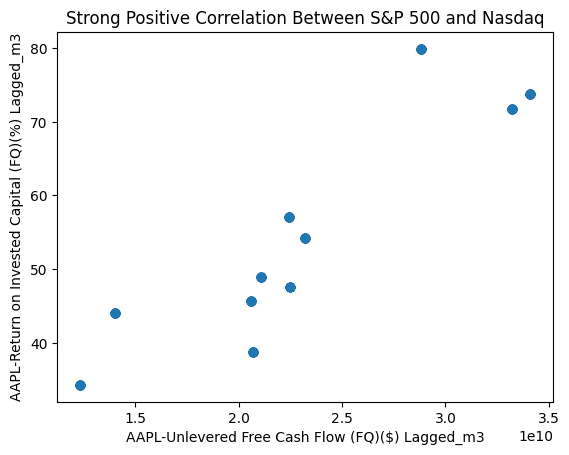

The correlation value between the two features are 0.895072322378156.


In [153]:
# check for multi-collinearity, some numeric columns have strings as data
df_numeric = df.drop(columns=['Pricing Date','AAPL-Net Income (FQ)($) Lagged_m3','AAPL-Total Revenue (FQ)($) Lagged_m3','Outperform','AAPL Monthly Return','S&P Monthly Return','NASDAQ Composite Price Return-Index Value (Daily) Lagged_m1'])
df_corr = df_numeric.corr()
# create and apply a mask to eliminate the correlation of one variable with itself
mask = np.triu(np.ones_like(df_corr, dtype=bool), k=1)
masked_corr = df_corr.where(mask)

# Find and plot the visualisation of the index of the most positive correlation value
max_corr_value = masked_corr.max().max()
max_corr_idx = masked_corr.stack()[masked_corr.stack() == max_corr_value].index

# identify the features
feature1 = max_corr_idx[0][0]
feature2 = max_corr_idx[0][1]

fig = plt.scatter(x=df[feature1], y=df[feature2], alpha=0.4)

# label the diagram
plt.title(f'Strong Positive Correlation Between S&P 500 and Nasdaq')
plt.xlabel(feature1)
plt.ylabel(feature2)

plt.show()
print(f"The correlation value between the two features are {max_corr_value}.")

I dropped a few variables that were showing up because they did not provide any additional new insight. For example, the NASDAQ and S&P 500 are very positively correlated because the companies which comprise majority of the S&P 500 are also in the NASDAQ.

I removed sales, ebit and net income because they are used to calculate each other and hence they would be highly correlated.

**Insight from high correlation between unlevered free cash flow and ROIC**

ROIC measures how efficiently a company is utilizing its capital - a high ROIC indicates that the company is efficiently using cash to generate higher profits. Unlevered free cash flow refers to the cash a company generates from its business after spending on machinery and equipment. Having a high correlation between these 2 features indicates that AAPL is an amazing company. It is able to generate cash and uses that cash efficiently to further fuel higher profits.



# Part 2 Supervised Learning (Modeling)


---



### Constructing training and test splits

In [154]:
# Constructing the training and testing data sets
X_train = df.drop(columns=['Outperform','AAPL Monthly Return','S&P Monthly Return'])[df['Pricing Date'] < df['Pricing Date'].max()- pd.DateOffset(days=28)]
y_train = df['Outperform'][df['Pricing Date'] < df['Pricing Date'].max()- pd.DateOffset(days=28)]

In [155]:
# Creating testing set

df_test =  access_excel_from_github('https://github.com/Nayrbnat/DS-112/raw/main/Qn3/AAPL%20Q3.xlsx', 'Data')
# Start Date
most_recent_date = df_data['Pricing Date'].max()
start_date = most_recent_date - pd.DateOffset(days=30)
df_data_test = df_data.iloc[:,:7]
df_quarter_test = df_quarter.iloc[:,:8]
# Selecting the quarters that don't appear in df_data
quarters_not_in_df_data = df_quarter_test[~df_quarter_test['Date'].isin(df_data_test['Pricing Date'])]
# Moving these selected dates back by 2 days
quarters_not_in_df_data['Date'] = quarters_not_in_df_data['Date'] - pd.DateOffset(days=3)

# Update df_quarter with these new dates
df_quarter_test.update(quarters_not_in_df_data)

# Merging
df_data_test = pd.merge(df_data_test, df_quarter_test, left_on = 'Pricing Date', right_on='Date', how = 'left').drop(columns =['Date'])
df_data_test = df_data_test[(df_data_test['Pricing Date'] >= start_date) & (df_data_test['Pricing Date'] <= most_recent_date)]
#Updating with most recent quarter
df_data_test.fillna(df_quarter.iloc[0,:7].to_dict(), inplace=True)
X_test = df_data_test


<ipython-input-155-a867b8355697>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quarters_not_in_df_data['Date'] = quarters_not_in_df_data['Date'] - pd.DateOffset(days=3)


In [156]:
#Checking the last date of the training set and the start date of the test set
print(X_train['Pricing Date'].max())
print(X_test['Pricing Date'].min())

# Given that the dates are correct, dropping the date column
X_train=X_train.drop(columns='Pricing Date')

2024-07-12 00:00:00
2024-07-15 00:00:00


In [157]:
df_test = df_test[(df_test['Pricing Date'] >= start_date) & (df_test['Pricing Date'] <= most_recent_date)]

# Creating the variable
df_test['AAPL Monthly Return'] = df_test['AAPL-Share Price (Daily)($)'] / df_test['AAPL-Share Price (Daily)($)'].shift(-21) - 1
df_test['S&P Monthly Return'] = df_test['S&P 500 Price Return-Index Value (Daily)'] / df_test['S&P 500 Price Return-Index Value (Daily)'].shift(-21) - 1

# Adding the outperform column
df_test['Outperform'] = np.where(df_test['AAPL Monthly Return'] > df_test['S&P Monthly Return'], 1, 0)
y_test = df_test['Outperform']


### Feature Selection - Logistic Regression

Given that we have so many variables, let us use backwards stepwise selection to find out optimal features for the Logistic Regression and KNeighbors model.

In [158]:
print(X_train.dtypes)

AAPL-Share Price (Daily)($) Lagged_m1                          float64
AAPL-Beta One Year (Country) Lagged_m1                         float64
S&P 500 Price Return-Index Value (Daily) Lagged_m1             float64
NASDAQ Composite Price Return-Index Value (Daily) Lagged_m1    float64
Inflation Lagged_m1                                            float64
SOFR Index Lagged_m1                                           float64
AAPL-Total Debt/ Total Equity (FQ)(x) Lagged_m3                float64
AAPL-Unlevered Free Cash Flow (FQ)($) Lagged_m3                float64
AAPL-Total Revenue (FQ)($) Lagged_m3                           float64
AAPL-EBIT (FQ)($) Lagged_m3                                    float64
AAPL-Net Income (FQ)($) Lagged_m3                              float64
AAPL-Return on Invested Capital (FQ)(%) Lagged_m3              float64
AAPL-Weighted Avg. Diluted Shares Out. (FQ) Lagged_m3          float64
dtype: object


In [159]:
# Feature Selection for logistic regression
random.seed(1)
log_reg = LogisticRegression(max_iter=10000)

sfs_log = SFS(log_reg,
          k_features='best',
          forward=False,
          floating=False,
          scoring='accuracy',
          cv=5)

sfs_log = sfs_log.fit(X_train, y_train)
selected_features_log = list(sfs_log.k_feature_names_)
print("Selected features:", selected_features_log)

Selected features: ['AAPL-Share Price (Daily)($) Lagged_m1', 'AAPL-Beta One Year (Country) Lagged_m1', 'S&P 500 Price Return-Index Value (Daily) Lagged_m1', 'NASDAQ Composite Price Return-Index Value (Daily) Lagged_m1', 'Inflation Lagged_m1', 'SOFR Index Lagged_m1', 'AAPL-Total Debt/ Total Equity (FQ)(x) Lagged_m3', 'AAPL-Unlevered Free Cash Flow (FQ)($) Lagged_m3', 'AAPL-Total Revenue (FQ)($) Lagged_m3', 'AAPL-EBIT (FQ)($) Lagged_m3', 'AAPL-Return on Invested Capital (FQ)(%) Lagged_m3', 'AAPL-Weighted Avg. Diluted Shares Out. (FQ) Lagged_m3']


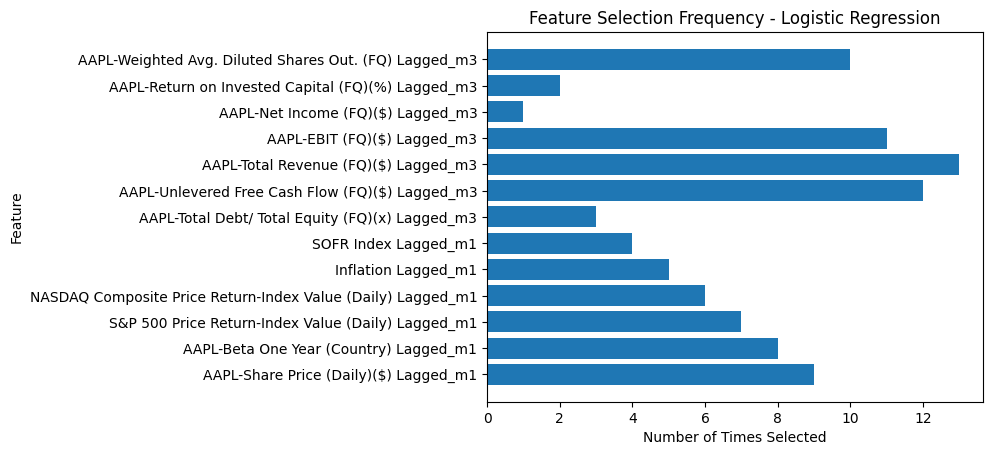

In [160]:
# Get feature selection history
random.seed(1)

feature_importances = sfs_log.subsets_

# Count how many times each feature was selected
feature_freq_log = np.zeros(len(X_train.columns))
for i in feature_importances:
    for j in feature_importances[i]['feature_idx']:
        feature_freq_log[j] += 1

# Plot feature selection frequencies
plt.barh(range(len(X_train.columns)), feature_freq_log, tick_label=X_train.columns)
plt.xlabel('Number of Times Selected')
plt.ylabel('Feature')
plt.title('Feature Selection Frequency - Logistic Regression')
plt.show()

### Feature Selection - KNN Classifier

In [161]:
# Feature Selection for logistic regression
random.seed(1)
knn = KNeighborsClassifier(n_neighbors=30)

sfs_knn = SFS(knn,
          k_features='best',
          forward=False,
          floating=False,
          scoring='accuracy',
          cv=5)

sfs_knn = sfs_knn.fit(X_train, y_train)
selected_features_knn= list(sfs_knn.k_feature_names_)
print("Selected features:", selected_features_knn)

Selected features: ['AAPL-EBIT (FQ)($) Lagged_m3']


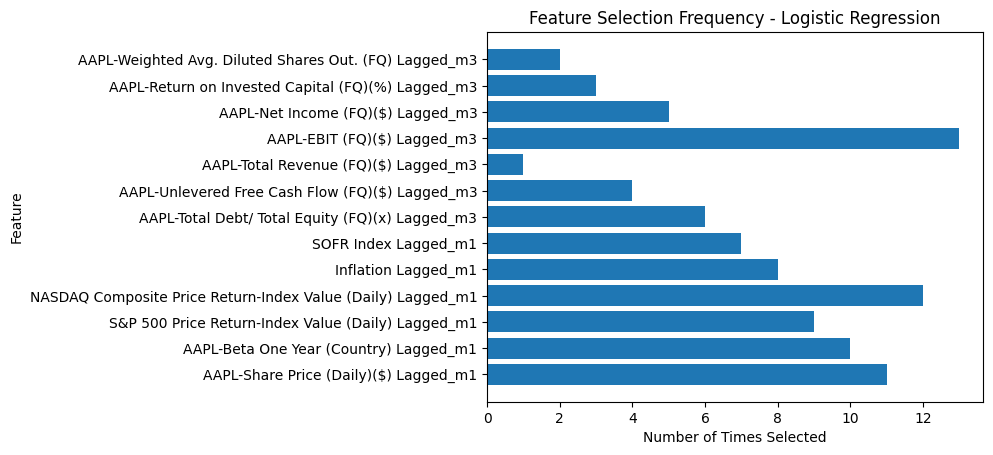

In [162]:
# Get feature selection history
random.seed(1)
feature_importances = sfs_knn.subsets_

# Count how many times each feature was selected
feature_freq_knn = np.zeros(len(X_train.columns))
for i in feature_importances:
    for j in feature_importances[i]['feature_idx']:
        feature_freq_knn[j] += 1

# Plot feature selection frequencies
plt.barh(range(len(X_train.columns)), feature_freq_knn, tick_label=X_train.columns)
plt.xlabel('Number of Times Selected')
plt.ylabel('Feature')
plt.title('Feature Selection Frequency - Logistic Regression')
plt.show()

### Comparing the Feature Frequency between logistic and KNN classifiers:

For both models **EBIT** seems to be a very important feature in predicting the outperformance of AAPL.

Logistic Regression seems to put greater weights on the fudamental data of AAPL - its net sales, operating income and net income.

KNN on the otherhand weighs the benchmarks - the beta of AAPL and its 1 month lagged share price, as well as the NASDAQ performance more heavily in its classification.

### Logistic Regression

In [163]:
# Initiating rolling window cross validation

tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

# Define the column transformer with a placeholder for the scaler
columntransformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), selected_features_log)
    ]
)

# Define the pipeline
pipe_log = Pipeline([
    ('preprocessor', columntransformer),
    ('classifier', LogisticRegression(max_iter=10000))
])

# Define the parameter grid
param_grid = {
    'preprocessor__scaler': [StandardScaler(), MinMaxScaler(), Normalizer()],
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__penalty': ['l1', 'l2'],  # L1 or L2 regularization
    'classifier__solver': ['liblinear', 'saga'],  # Solvers that support L1 and L2
    'classifier__class_weight': [None, 'balanced']  # Handling imbalanced classes
}

# Set up GridSearchCV
cv_log = GridSearchCV(
    estimator=pipe_log,
    param_grid=param_grid,
    cv=tscv,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit the GridSearchCV
cv_log.fit(X_train, y_train)

# Extract best parameters and results
print("Best parameters found: ", cv_log.best_params_)
print("Best cross-validation accuracy: ", cv_log.best_score_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


In [ ]:
# cross-val predict on training data
log_predict = cross_val_predict(cv_log.best_estimator_, X_train, y_train)

In [ ]:
# Confusion Matrix for Logistic Regression on training data
conf_mat = confusion_matrix(y_train, log_predict)
conf_mat_df_log = pd.DataFrame(conf_mat, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
conf_mat_df_log

In [ ]:
# Computing precision, recall, F1-score on training data
log_accuracy = accuracy_score(y_train, log_predict)
log_precision = precision_score(y_train, log_predict)
log_recall = recall_score(y_train, log_predict)
log_f1 = f1_score(y_train, log_predict)

In [ ]:
# Combining Logistic Regression results in a dataframe
log_results_train = pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Precision': [log_precision],
    'Recall': [log_recall],
    'F1-Score': [log_f1],
    'Accuracy': [log_accuracy]
})
log_results_train

### Kneighbors Classifer

Given that the feature selection only picked out 1 feature, let us use that to optimize!

In [ ]:
# Define the column transformer with a placeholder for the scaler
# Define the column transformer with a placeholder for the scaler
columntransformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), selected_features_knn)
    ]
)

# Define the pipeline
pipe_knn = Pipeline([
    ('preprocessor', columntransformer),
    ('classifier', KNeighborsClassifier())
])

# Define the parameter grid
param_grid = {
    'preprocessor__scaler': [StandardScaler(), MinMaxScaler(), Normalizer()],
    'classifier__n_neighbors': [3, 5, 7, 10, 15],  # Number of neighbors
    'classifier__weights': ['uniform', 'distance'],  # Weight function used in prediction
    'classifier__p': [1, 2],  # Power parameter for the Minkowski distance
}

# Set up GridSearchCV
cv_knn = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid,
    cv=tscv,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit the GridSearchCV
cv_knn.fit(X_train, y_train)

# Extract best parameters and results
print("Best parameters found: ", cv_knn.best_params_)
print("Best cross-validation accuracy: ", cv_knn.best_score_)


In [ ]:
# cross-val predict on training data
knn_predict = cross_val_predict(cv_knn.best_estimator_, X_train, y_train)

In [ ]:
# Confusion Matrix for Logistic Regression on training data
conf_mat = confusion_matrix(y_train, knn_predict)
conf_mat_df_knn = pd.DataFrame(conf_mat, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
conf_mat_df_knn

In [ ]:
# Computing precision, recall, F1-score on training data
knn_accuracy = accuracy_score(y_train, knn_predict)
knn_precision = precision_score(y_train, knn_predict)
knn_recall = recall_score(y_train, knn_predict)
knn_f1 = f1_score(y_train, knn_predict)

In [ ]:
# Combining Logistic Regression results in a dataframe
knn_results_train = pd.DataFrame({
    'Model': ['Kneighbors Classifer'],
    'Precision': [knn_precision],
    'Recall': [knn_recall],
    'F1-Score': [knn_f1],
    'Accuracy': [knn_accuracy]
})
train_result = pd.merge(knn_results_train, log_results_train, how='outer')
train_result

## Conclusion from Initial Cross-Validation on training set

It would appear that the logistic regression with 1 predictor outperforms the logistic regression with many predictors on the training data.

Cross Validation accuracy of KNN: 60%

Cross Validation accuracy of logistic regression: 60.2%

We observe however, that in light of the cross-validation error, KNN performs slightly worse than the logistic regression. This is due to the bias-variance trade-off.

As a non-parametric model, KNN has a higher chance of overfitting the data, resulting in higher variance and lower ability to generalize to new data.

That being said, the final test remains... how do these 2 models perform on the holdout set

# The Final Challenge - Testing on the hold-out set

Due to the difference in naming, I need to map the column of X_train over

In [ ]:
X_train

In [ ]:
# Mapping column names of X_train to X_test
# Number of columns to apply '_Lagged_m1'
n_lagged_m1 = 7

# Create a dictionary with the new column names
new_column_names = {
    col: (col + ' Lagged_m1' if i < n_lagged_m1 else col + ' Lagged_m3')
    for i, col in enumerate(X_test.columns)
}

# Rename the columns in X_test
X_test = X_test.rename(columns=new_column_names)

In [ ]:
knn_predict_test = cv_knn.best_estimator_.predict(X_test)
log_predict_test = cv_log.best_estimator_.predict(X_test)

Given that in the holdout set, it only contains 1 of each class, we are unable to generate a confusion matrix, let us compute the accuracy instead

In [ ]:
# Accuracy for KNN
accuracy_score(y_test, knn_predict_test)

In [ ]:
# Accuracy for Logistic Regression
accuracy_score(y_test, log_predict_test)

In [ ]:
# Training Results
train_result

In [ ]:
df_quarter['AAPL-EBIT (FQ)($)'].head()

# Conclusion

It appears that our logistic regression predicted correctly over the 21 days. Conversely, the KNN model predicted the values completely wrongly!

**Limitations of study**

As you can see our holdout-set in this case was very limited for 21 days with a significant class imbalance. It is likely that our model will be right less than 68% of the time over a large enough test dataset.

**Main Takeaways**

We observed that these models do decently predict whether AAPL stock price will outperform the S&P 500 over 1 month. We are also able to identify important key features which lead to such predictions! An example would be the EBIT (Earnings before Interest and Taxes) that is generated.

We also observe the likelihood of the KNN model to overfit. Given that KNN was predicting heavily on EBIT, when AAPL stock released quarterly earnings with EBIT falling in the latest quarter, the model predicted that the stock would underperform the S&P. This however is not true as analysts often pay attention to year over year change rather than EBIT changes over the quarter as well.

Hence to improve the model, we could have expanded the feature space to improve predictive power.


In [ ]:
# @markdown Run this cell to download this notebook as a webpage, `_NOTEBOOK.html`.

import google, json, nbformat

# Get the current notebook and write it to _NOTEBOOK.ipynb
raw_notebook = google.colab._message.blocking_request("get_ipynb",
                                                      timeout_sec=30)["ipynb"]
with open("_NOTEBOOK.ipynb", "w", encoding="utf-8") as ipynb_file:
  ipynb_file.write(json.dumps(raw_notebook))

# Use nbconvert to convert .ipynb to .html.
!jupyter nbconvert --to html --log-level WARN _NOTEBOOK.ipynb

# Download the .html file.
google.colab.files.download("_NOTEBOOK.html")